<a href="https://colab.research.google.com/github/jaw039/Google-Colab-Notebooks/blob/main/Copy_of_CSE_151A_Week_4_Discussion_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## Welcome to the Week 4 Discussion!

Hello everyone! Today, we're going to build on the lecture material and get you fully prepared for Homework 3 and SA4. We'll focus on implementing key algorithms from scratch to ensure you understand how they work under the hood.

**Our agenda for today:**
1.  K means clustering algorithm
2.  Hierarchial Clustering
3.  Singular Value Decomposition (SVD)
4.  Principal Component Analysis (PCA)

## Generate Dataset


In [ ]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=100, centers=4, n_features=2, random_state=42)

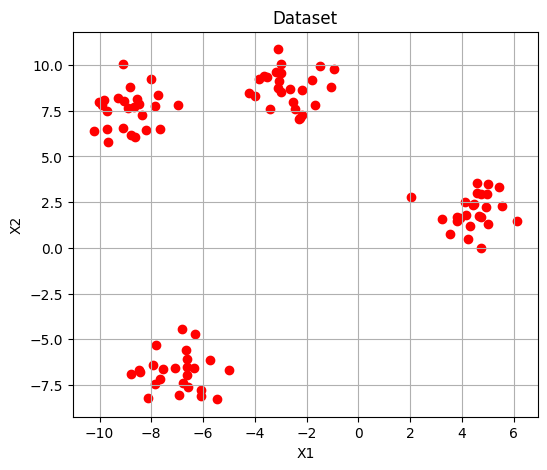

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c='red')
plt.title('Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

## K-Means Clustering

K-Means is an iterative partitioning clustering algorithm that aims to partition $n$ observations into $k$ clusters, where each observation belongs to the cluster with the nearest mean (centroid).

[![k-means-clustering.png](https://i.postimg.cc/xdgfDNG6/k-means-clustering.png)](https://postimg.cc/Z9Bt6RMN)

**Algorithm Steps:**

1.  **Initialization**: Choose $k$ initial centroids. This is often done randomly from the data points.
2.  **Assignment**: Assign each data point to the nearest centroid based on a distance metric (commonly Euclidean distance).
    $$ \text{cluster}_i = \{ \mathbf{x} \mid \| \mathbf{x} - \mathbf{c}_i \|^2 \le \| \mathbf{x} - \mathbf{c}_j \|^2 \quad \forall j \ne i \} $$
    where $\mathbf{x}$ is a data point, and $\mathbf{c}_i$ and $\mathbf{c}_j$ are centroids.
3. **Update**: Recalculate the centroids for each cluster as the mean of all data points assigned to that cluster:
$$
\mathbf{c}_i = \frac{1}{|\text{cluster}_i|} \sum_{\mathbf{x} \in \text{cluster}_i} \mathbf{x}
$$

4.  **Convergence**: Repeat steps 2 and 3 until the centroids no longer change significantly or a maximum number of iterations is reached.

**Objective Function:**

K-Means aims to minimize the within-cluster sum of squares (WCSS), also known as inertia:
$$ \text{WCSS} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in \text{cluster}_i} \| \mathbf{x} - \mathbf{c}_i \|^2 $$

It is the sum of squared distances from each data point to the center of its assigned cluster. It tells us how well the points are grouped in their clusters. The smaller the WCSS the better the clustering.

## K-means clustering implementation



In [ ]:
import numpy as np

def kmeans_from_scratch(X, n_clusters, max_iter=300, random_state=None):
    """
    K-Means clustering from scratch using NumPy.

    Parameters
    ----------
    X : (n_samples, n_features) ndarray
        The input data.
    n_clusters : int
        The number of clusters. This is same as k.
    max_iter : int
        Maximum number of iterations for the K-Means algorithm.
    random_state : int or np.random.Generator or None
        Seed for random number generation.

    Returns
    -------
    labels : (n_samples,) ndarray
        Cluster labels for each sample.
    centers : (n_clusters, n_features) ndarray
        Cluster centers.
    """
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape

    # 1. Initialize cluster centers
    # Randomly pick n_clusters data points as initial centers
    random_indices = rng.choice(n_samples, size=n_clusters, replace=False)
    centers = X[random_indices]

    for _ in range(max_iter):
        # 2. Assign each data point to the nearest center
        # Calculate distances between each data point and each center
        distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
        # Assign each point to the cluster with the minimum distance
        labels = np.argmin(distances, axis=0)

        # 3. Update cluster centers
        new_centers = np.array([X[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centers[i] for i in range(n_clusters)])

        # 4. Check for convergence
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return labels, centers

# Apply K-Means from scratch algorithm
cluster_labels_scratch, cluster_centers_scratch = kmeans_from_scratch(X, n_clusters=4, random_state=42)

print("Cluster Labels (first 10 points in the dataset):", cluster_labels_scratch[:10])
print("Cluster Centers:\n", cluster_centers_scratch)

Cluster Labels (first 10 points in the dataset): [2 3 0 3 2 3 1 1 1 0]
Cluster Centers:
 [[-2.69827251  8.74341951]
 [ 4.44441765  2.02122148]
 [-8.8546122   7.54808242]
 [-6.9749469  -6.76471966]]


Text(0, 0.5, 'Feature 2')

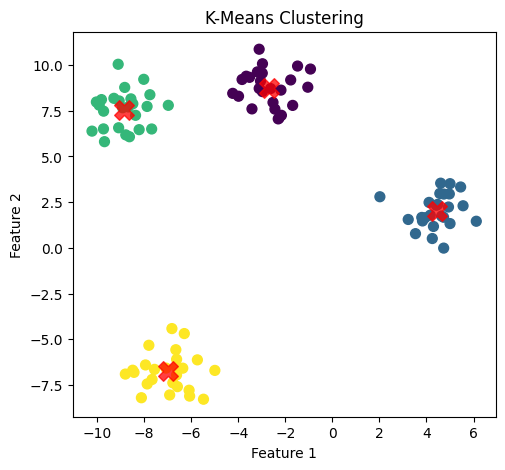

In [ ]:
import matplotlib.pyplot as plt

# Visualize K-Means results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_scratch, s=50, cmap='viridis')
plt.scatter(cluster_centers_scratch[:, 0], cluster_centers_scratch[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

### How to find the best value of k?
The goal is to find the value of K where the decrease in the WCSS error starts to slow down. This is like an "elbow" in the plot where the curve bends and flattens out. The number of clusters at this point is considered the optimal value for K.

[![elbow.png](https://media.geeksforgeeks.org/wp-content/uploads/elbow_3.jpeg)](https://media.geeksforgeeks.org/wp-content/uploads/elbow_3.jpeg)


## Hierarchical Clustering
Hierarchical clustering builds a hierarchy of clusters, either by merging small clusters into larger ones (agglomerative) or by splitting large clusters into smaller ones (divisive).

Agglomerative (bottom-up): start with each point as its own cluster, and keep merging the closest ones.

Divisive (top-down): start with all points in one cluster, and keep splitting them apart.

We will focus on the more common agglomerative approach.

**Agglomerative Algorithm Steps:**

1.  **Initialization**: Start with each data point as its own cluster.
2.  **Merging**: Iteratively merge the two closest clusters based on a chosen linkage criterion.
3.  **Termination**: Continue merging until only one cluster remains or a desired number of clusters is reached.

[![hierarchial-clustering.png](https://i.postimg.cc/9MWDyjbn/hierarchial-clustering.png)](https://postimg.cc/PLRfk9BW)

**Distance Metrics:**

The distance between data points is typically measured using metrics like Euclidean distance:
$$ d(\mathbf{x}_i, \mathbf{x}_j) = \| \mathbf{x}_i - \mathbf{x}_j \|_2 $$

**Linkage Criteria:**

The linkage criterion determines how the distance between two clusters is calculated. Common criteria include:

*   **Single Linkage**: The minimum distance between any two points in the two clusters.
    $$ D(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
*   **Complete Linkage**: The maximum distance between any two points in the two clusters.
    $$ D(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
*   **Average Linkage**: The average distance between all pairs of points in the two clusters.
    $$ D(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
*   **Ward's Method**: Minimizes the variance of the merged cluster. It calculates the increase in the total within-cluster sum of squares after merging.
    $$ \Delta(C_i, C_j) = \text{WCSS}(C_i \cup C_j) - (\text{WCSS}(C_i) + \text{WCSS}(C_j)) $$

The result of hierarchical clustering is often visualized as a dendrogram, which shows the sequence of merges and the distances at which they occurred.

##Hierarchical Clustering Implementation

In [ ]:
import numpy as np

def euclidean_distance(p1, p2):
    """Calculates the Euclidean distance between two points."""
    return np.sqrt(np.sum((p1 - p2)**2))

def calculate_cluster_distance(cluster1, cluster2, linkage_method='single'):
    """
    Calculates the distance between two clusters based on the linkage method.

    Parameters
    ----------
    cluster1, cluster2 : list of indices
        Lists of indices of data points belonging to each cluster.
    linkage_method : str
        'single', 'complete', or 'average'.

    Returns
    -------
    distance : float
        The calculated distance between the clusters.
    """
    if linkage_method == 'single':
        return min(euclidean_distance(X[i], X[j]) for i in cluster1 for j in cluster2)
    elif linkage_method == 'complete':
        return max(euclidean_distance(X[i], X[j]) for i in cluster1 for j in cluster2)
    elif linkage_method == 'average':
        return np.mean([euclidean_distance(X[i], X[j]) for i in cluster1 for j in cluster2])
    else:
        raise ValueError("Invalid linkage method")


def hierarchical_clustering_from_scratch(X, n_clusters, linkage_method='single'):
    """
    Agglomerative Hierarchical Clustering from scratch using NumPy.

    Parameters
    ----------
    X : (n_samples, n_features) ndarray
        The input data.
    n_clusters : int
        The desired number of clusters to stop at.
    linkage_method : str
        'single', 'complete', 'average'.

    Returns
    -------
    labels : (n_samples,) ndarray
        Cluster labels for each sample.
    """
    n_samples = X.shape[0]
    # Initially, each data point is its own cluster
    clusters = [[i] for i in range(n_samples)]
    print(f"No. of clusters in first iteration: {len(clusters)}")
    print(clusters)

    # Merge clusters until the desired number of clusters is reached
    while len(clusters) > n_clusters:
        min_distance = float('inf')
        merge_indices = (-1, -1)

        # Find the two closest clusters
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = calculate_cluster_distance(clusters[i], clusters[j], linkage_method)
                if dist < min_distance:
                    min_distance = dist
                    merge_indices = (i, j)

        # Merge the two closest clusters
        idx1, idx2 = merge_indices
        merged_cluster = clusters[idx1] + clusters[idx2]
        clusters.pop(idx2) # Remove the second cluster first to avoid index issues
        clusters.pop(idx1)
        clusters.append(merged_cluster)

    print(f"\nNo. of clusters after final iteration: {len(clusters)}")
    for i in clusters:
      print(i)

    # Assign labels based on the final clusters
    labels = np.zeros(n_samples, dtype=int)
    for i, cluster in enumerate(clusters):
        for data_index in cluster:
            labels[data_index] = i

    return labels

# Apply Hierarchical Clustering from scratch
hierarchical_labels = hierarchical_clustering_from_scratch(X, n_clusters=4, linkage_method='single')

print("\nHierarchical Cluster Labels (first 10 data points):", hierarchical_labels[:10])

No. of clusters in first iteration: 100
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99]]

No. of clusters after final iteration: 4
[92, 59, 88, 86, 34, 96, 94, 14, 25, 43, 9, 56, 37, 2, 95, 10, 44, 20, 35, 82, 73, 57, 85, 36, 84]
[87, 66, 93, 78, 29, 91, 63, 46, 79, 3, 5, 81, 42, 1, 76, 11, 30, 45, 60, 74, 32, 53, 69, 12, 71]
[64, 83, 54, 48, 98, 75, 19, 18, 28, 15, 72, 22, 55, 16, 4, 21, 47, 0, 40, 67, 62, 65, 77, 27, 33]
[50, 58, 13, 39, 89, 38, 6, 8, 

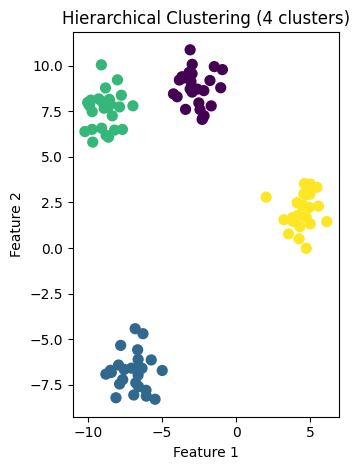

In [ ]:
# Visualize Hierarchical Clustering results
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=hierarchical_labels, s=50, cmap='viridis')
plt.title('Hierarchical Clustering (4 clusters)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

###TODO - Discussion Participation

1. What do you think are advantages of hierarchical clustering over K-Means? What are disadvantages?

2. Do you think K means is sensitive to outliers? Explain with reasoning.

## Dimensionality Reduction

#### Curse of Dimensionality
Real world datasets way too many features in the dataset, hard to visualize them and maybe some of them are redundant or sparse. <br >
The model would also have a hard time if its computational complexity scales with the number of features.

### In a Nutshell
**Find a low-dimensional representation that preserves the original information in high-dimensional space as much as possible.** <br >
What do we mean by original information? <br >
Global information like the variance(richness) in the dataset, the pairwise distance/similarity in the dataset. <br >



PCA is a **linear** dimensionality reduction method that preserves **variances**. <br >
PCA can use SVD to perform dimensionality reduction.

## Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a powerful matrix factorization technique that decomposes any matrix $A$ into three other matrices: $U$, $S$, and $V^T$.

Mathematically, SVD is represented as:

$$ A = U S V^T $$

Where:
- $A$ is the original matrix of shape $(m, n)$.
- $U$ is an orthogonal matrix of shape $(m, r)$ whose columns are the left singular vectors of $A$.
- $S$ is a diagonal matrix of shape $(r, r)$ containing the singular values of $A$ on the diagonal, in descending order. The singular values are the square roots of the eigenvalues of $A^T A$ (or $A A^T$).
- $V^T$ is the transpose of an orthogonal matrix $V$ of shape $(r, n)$ whose rows are the right singular vectors of $A$. The columns of $V$ are the eigenvectors of $A^T A$.
- Here, r = Rank(A) i.e. the number of nonzero singular values. It represents the effective dimensionality of the information in A.

SVD has numerous applications, including dimensionality reduction, noise reduction, and recommender systems.

## Algorithm

Given **A** (m×n):

1. Compute **M** = **A**ᵀ**A**.

2. Solve the eigenproblem **Mvᵢ = λᵢvᵢ**. \
Order eigenvalues λ₁ ≥ λ₂ ≥ ⋯ ≥ 0 and take corresponding orthonormal eigenvectors **v**ᵢ. (These are the columns of **V**.)

3. Set σᵢ = √λᵢ. Form **Σ** with σᵢ on the diagonal (same ordering).

4. For each σᵢ > 0, compute **u**ᵢ = **(1/σᵢ)Avᵢ**. These are orthonormal automatically for distinct σᵢ; collect them as columns of **U**.

5. If you need a full **U** and there are fewer than m nonzero singular values, extend {**u**ᵢ} to an orthonormal basis of ℝᵐ (Gram–Schmidt or eigen-decompose **AA**ᵀ).

6. Check **A** = **U****Σ****V**ᵀ.

In [ ]:
import numpy as np

def svd_from_scratch(A, epsilon=1e-12):
    """
    Computes the Singular Value Decomposition of a matrix A using NumPy from scratch.

    Parameters
    ----------
    A : (m, n) array_like
        The input matrix.
    epsilon : float
        A small value to handle numerical stability when dividing by singular values.

    Returns
    -------
    U : (m, r) ndarray
        The left singular vectors as columns (r = rank).
    s : (r,) ndarray
        The singular values in descending order.
    Vt : (r, n) ndarray
        The right singular vectors as rows (V transposed).
    """
    m, n = A.shape

    # 1) Form A^T A and eigen-decompose it
    M = A.T @ A  # (n, n)
    eigvals, eigvecs = np.linalg.eig(M)

    # 2) Sort eigenvalues/vectors descending (so sigma1 >= sigma2)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    V = eigvecs[:, idx]  # (n, n) - right singular vectors

    # 3) Keep only positive eigenvalues (within numerical precision)
    positive_mask = eigvals > epsilon
    eigvals = eigvals[positive_mask]
    V = V[:, positive_mask]  # (n, r) where r = number of positive eigenvalues

    # 4) Singular values are sqrt(eigenvalues)
    sigmas = np.sqrt(eigvals)  # (r,)
    r = len(sigmas)

    # 5) Left singular vectors: u_i = (A v_i) / sigma_i
    U = np.zeros((m, r))
    for i in range(r):
        if sigmas[i] > epsilon:
            U[:, i] = (A @ V[:, i]) / sigmas[i]

    return U, sigmas, V.T  # Return V.T to match numpy's convention

def round_matrix(x):
    return np.round(x, 4)

# Test the implementation
A = np.array([[1, 2], [3, 4], [5, 6]], dtype=float)
print("Original matrix A:")
print(A)
print("Shape of A:", A.shape)

# Our implementation
U, s, Vt = svd_from_scratch(A)
print(f"\nOur SVD - U shape: {U.shape}, s shape: {s.shape}, Vt shape: {Vt.shape}")

# Reconstruct A
r = len(s)
Sigma_rect = np.zeros((r, r))
np.fill_diagonal(Sigma_rect, s)
recon = U @ Sigma_rect @ Vt

print("\nOur reconstruction:")
print("A_reconstructed:\n", round_matrix(recon))
print("Singular values:", round_matrix(s))
print("U:\n", round_matrix(U))
print("Vt:\n", round_matrix(Vt))

print("\n" + "="*50)
print("NumPy SVD for comparison:")

# NumPy implementation
U_np, s_np, Vt_np = np.linalg.svd(A, full_matrices=False)
recon_np = U_np @ np.diag(s_np) @ Vt_np

print(f"NumPy SVD - U shape: {U_np.shape}, s shape: {s_np.shape}, Vt shape: {Vt_np.shape}")
print("NumPy reconstruction:\n", round_matrix(recon_np))
print("NumPy singular values:", round_matrix(s_np))
print("NumPy U:\n", round_matrix(U_np))
print("NumPy Vt:\n", round_matrix(Vt_np))

# Check if reconstructions match
print(f"\nReconstruction error: {np.linalg.norm(recon - A):.2e}")
print(f"Difference from NumPy: {np.linalg.norm(recon - recon_np):.2e}")

Original matrix A:
[[1. 2.]
 [3. 4.]
 [5. 6.]]
Shape of A: (3, 2)

Our SVD - U shape: (3, 2), s shape: (2,), Vt shape: (2, 2)

Our reconstruction:
A_reconstructed:
 [[1. 2.]
 [3. 4.]
 [5. 6.]]
Singular values: [9.5255 0.5143]
U:
 [[-0.2298  0.8835]
 [-0.5247  0.2408]
 [-0.8196 -0.4019]]
Vt:
 [[-0.6196 -0.7849]
 [-0.7849  0.6196]]

NumPy SVD for comparison:
NumPy SVD - U shape: (3, 2), s shape: (2,), Vt shape: (2, 2)
NumPy reconstruction:
 [[1. 2.]
 [3. 4.]
 [5. 6.]]
NumPy singular values: [9.5255 0.5143]
NumPy U:
 [[-0.2298  0.8835]
 [-0.5247  0.2408]
 [-0.8196 -0.4019]]
NumPy Vt:
 [[-0.6196 -0.7849]
 [-0.7849  0.6196]]

Reconstruction error: 1.40e-15
Difference from NumPy: 1.82e-15


###TODO - Discussion Participation
1. Why are singular values always nonnegative?

2. What happens if rank 𝑟 < min(𝑚,𝑛)?  
Hint: Think about what happens to the eigenvalues?

## Principal Component Analysis (PCA)

It finds a linear mapping to project the data into low-dimensional space such that **the variances of the low-dimensional representation are maximized**.

### How It Works From a High Level
The low-dimensional space is spanned by **principal components** (they comprise the linear mapping). <br >

Principal components are orthogonal(uncorrelated) to each other, so that they will not describe the same information. <br >

Each principal component will try to align to the maximum variance in the dataset, by maximizing the distance between the projected data point and the origin (sum of squares).

The principal components are the eigenvectors of the covariance matrix of the data, and the eigenvalues correspond to the variance explained by each component.

[![pca.jpg](https://i.postimg.cc/3N82rvzW/pca.jpg)](https://postimg.cc/DJNSB8vK)


**Algorithm Steps:**

1.  **Standardize the Data**: Center the data by subtracting the mean of each feature. Optionally, scale the data by dividing by the standard deviation.
    $$ X_{centered} = X - \bar{X} $$
2.  **Compute the Covariance Matrix**: Calculate the covariance matrix of the centered data.
    $$ \text{Cov}(X_{centered}) = \frac{1}{n-1} X_{centered}^T X_{centered} $$
3.  **Compute Eigenvalues and Eigenvectors**: Calculate the eigenvalues and eigenvectors of the covariance matrix.
    $$ \text{Cov}(X_{centered}) \mathbf{w} = \lambda \mathbf{w} $$
    where $\lambda$ is an eigenvalue and $\mathbf{w}$ is an eigenvector.
4.  **Sort Eigenpairs**: Sort the eigenvalues in descending order and arrange the corresponding eigenvectors (principal components) accordingly.
5.  **Select Principal Components**: Choose the top $k$ eigenvectors to form a projection matrix.
6.  **Project Data**: Transform the original centered data onto the new lower-dimensional space defined by the selected principal components.
    $$ Z = X_{centered} W $$
    where $W$ is the matrix of the top $k$ eigenvectors.

The explained variance ratio for each component indicates the proportion of the total variance in the data that is captured by that component.

$$ \text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^n \lambda_j} $$

**NOTE:** PCA is closely related to SVD. The columns of V (right singular vectors) are the principal components. So PCA can be done directly with SVD, without forming the covariance matrix.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def pca_from_scratch(X, n_components, center=True):
    """
    Performs Principal Component Analysis (PCA) on a dataset using NumPy from scratch.
    """
    X = np.asarray(X, dtype=float)
    n_samples, n_features = X.shape

    # 1. Center the data
    mean_ = X.mean(axis=0) if center else np.zeros(n_features)
    Xc = X - mean_

    # 2. Compute the covariance matrix
    cov_matrix = (Xc.T @ Xc) / max(n_samples - 1, 1)

    # 3. Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # 4. Sort by eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    lambdas = eigenvalues[sorted_indices]
    W = eigenvectors[:, sorted_indices]  # eigenvectors as columns

    # 5. Keep top components
    lambdas = lambdas[:n_components]
    W = W[:, :n_components]

    # 6. Project the data
    Z = Xc @ W

    # Explained variance ratio
    total_variance = np.sum(np.diag(eigenvalues))
    explained_variance_ratio = lambdas / (total_variance + 1e-32)

    return Z, W, explained_variance_ratio


# ==== Example dataset (10 samples, 3 features -> project to 2D) ====
X = np.array([
    [2.5, 2.4, 1.2],
    [0.5, 0.7, 1.8],
    [2.2, 2.9, 0.9],
    [1.9, 2.2, 1.5],
    [3.1, 3.0, 2.1],
    [2.3, 2.7, 1.4],
    [2.0, 1.6, 0.8],
    [1.0, 1.1, 1.0],
    [1.5, 1.6, 1.7],
    [1.1, 0.9, 0.6]
])

# Apply PCA (scratch implementation)
Z, W, evr = pca_from_scratch(X, n_components=2, center=True)

print(f"Original Data:\n", X)
print("\n=================== Implementation from Scratch ====================")
print("\nProjected data (Z):\n", Z)
print("\nPCA components (W):\n", W.T)
print("\nExplained variance ratio:\n", evr)

print("\n================ Sklearn implementation =========================")
pca = PCA(n_components=2)
Z_sklearn = pca.fit_transform(X)
print("\nProjected data (Z):\n", Z_sklearn)
print("\nScikit-learn PCA components:\n", pca.components_)
print("\nExplained variance ratio:\n", pca.explained_variance_ratio_)


Original Data:
 [[2.5 2.4 1.2]
 [0.5 0.7 1.8]
 [2.2 2.9 0.9]
 [1.9 2.2 1.5]
 [3.1 3.  2.1]
 [2.3 2.7 1.4]
 [2.  1.6 0.8]
 [1.  1.1 1. ]
 [1.5 1.6 1.7]
 [1.1 0.9 0.6]]

=================== Implementation from Scratch ====================

Projected data (Z):
 [[ 0.8091544  -0.21161979]
 [-1.7022591   0.72274344]
 [ 0.93572635 -0.49492703]
 [ 0.29690182  0.17229639]
 [ 1.7614074   0.57341181]
 [ 0.91849175 -0.00263982]
 [-0.16033321 -0.50436419]
 [-1.17277192 -0.15345995]
 [-0.38539002  0.45120667]
 [-1.30092747 -0.55264754]]

PCA components (W):
 [[ 0.67195554  0.73026454  0.1232455 ]
 [-0.12819212 -0.04921321  0.99052756]]

Explained variance ratio:
 [0.83021513 0.13885146]

================ Sklearn implementation =========================

Projected data (Z):
 [[ 0.8091544  -0.21161979]
 [-1.7022591   0.72274344]
 [ 0.93572635 -0.49492703]
 [ 0.29690182  0.17229639]
 [ 1.7614074   0.57341181]
 [ 0.91849175 -0.00263982]
 [-0.16033321 -0.50436419]
 [-1.17277192 -0.15345995]
 [-0.3853900

# Implement Calculation of Eigenvalues and Eigenvectors from scratch
We use QR decomposition to find out the eigenvalues.

The basic idea of QR decomposition is writing the matrix as a product of an orthogonal matrix and an upper triangular matrix, multiply the factors in the reverse order, and iterate. We keep on iterating till we can convert the input matrix into a diagonal matrix form.

**NumPy equivalent - np.linalg.eig(matrix)**


In [ ]:
import numpy as np

def eigen_qr(A, max_iter=1000, tol=1e-10):
    """
    Compute eigenvalues and eigenvectors of a square matrix using the QR algorithm.

    Args:
        A (np.ndarray): Square matrix
        max_iter (int): Maximum number of iterations
        tol (float): Convergence tolerance

    Returns:
        eigenvalues (np.ndarray)
        eigenvectors (np.ndarray)
    """
    n = A.shape[0]
    A = A.astype(float)

    # Initialize the accumulator for the eigenvectors.
    # After convergence, columns of Q_total approximate eigenvectors of the original A.
    Q_total = np.eye(n)

    for _ in range(max_iter):
        # QR factorization: A = Q R with Q orthonormal and R upper-triangular.
        # NumPy uses a stable method (Householder reflections) under the hood.
        Q, R = np.linalg.qr(A)

        # Similarity-like update: A_{k+1} = R @ Q
        # Since A = Q R, we can show Q^T A Q = R Q (for orthonormal Q, Q^T = Q^{-1}).
        # Repeatedly applying this tends to push A toward upper-triangular form.
        A = R @ Q

        # Accumulate the Q's to build eigenvectors:
        # If A_k ≈ Q_total @ T @ Q_total^T with T ≈ diagonal, then
        # A_original @ Q_total ≈ Q_total @ T, so columns of Q_total are eigenvectors.
        Q_total = Q_total @ Q

        # Convergence check:
        # We measure "how non-diagonal" A is by zeroing out the diagonal and
        # taking the Frobenius norm of the remaining entries. As the iteration
        # converges, off-diagonal terms shrink toward 0.
        off_diag_norm = np.linalg.norm(A - np.diag(np.diagonal(A)))

        # If the off-diagonal is sufficiently small, we consider the matrix
        # effectively triangular/diagonal and stop iterating.
        if off_diag_norm < tol:
            break

    # After convergence (or hitting max_iter), the diagonal entries of A are
    # our eigenvalue estimates. Note: no guaranteed sorting.
    eigenvalues = np.diagonal(A)

    # Columns of Q_total are the corresponding eigenvectors.
    # They are already orthonormal because each Q was orthonormal.
    eigenvectors = Q_total

    return eigenvalues, eigenvectors


# Example
A = np.array([[4, 2, 1],
              [0, 3, -1],
              [0, 0, 2]], dtype=float)

vals, vecs = eigen_qr(A)

print("Input Matrix:\n", A)
print("\nEigenvalues:\n", vals)
print("\nEigenvectors (columns correspond to eigenvalues):\n", vecs)


Input Matrix:
 [[ 4.  2.  1.]
 [ 0.  3. -1.]
 [ 0.  0.  2.]]

Eigenvalues:
 [4. 3. 2.]

Eigenvectors (columns correspond to eigenvalues):
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
